# Лабораторная работа № 8
## Динамические сети

**Целью работы** является исследование свойств некоторых динамических нейронных сетей,алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распознавания динамических образов.

In [1]:
# pip install pyrenn

In [2]:
# pip install fireTS

In [3]:
# pip install -U scikit-learn scipy matplotlib

In [4]:
# pip install fireTS

In [5]:
# pip install sklearn

In [6]:
# pip3 install -U scikit-learn scipy matplotlib

In [7]:
from sklearn.metrics import r2_score, mean_squared_error

In [8]:
import neurolab as nl
import numpy as np
import numpy.matlib
from sklearn.metrics import mean_squared_error
import pyrenn
from matplotlib import pyplot as plt
import math
import neurolab as nl
import random
import sklearn
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neural_network import MLPRegressor
from fireTS.models import NARX
import warnings
warnings.filterwarnings('ignore')

c:\python372\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python372\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python372\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python372\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

**Вариант №4:** 

1. $10/1848$
2. $g(k) = \sin{(\sin{(k)}k^3 − 10)}, \: k \in [1.56, 3.12]$
3. $u(k) = \sin{(k^2 − 7k)}$

In [9]:
date = "1913-05-01"
# a = 1.56
# b = 3.12
R = [0, 1, 5] # delays

def g(k):
    return np.sin(np.sin(k) * k**3 - 10)

def u(k):
    return np.cos(-k**2 - 8*k) + np.cos(k)**2

def f(k):
    y = [0.]
    for i in k:
        y.append(y[-1] / (1 + y[-1]**2) + u(i)**3)
    return y[:-1]

### Задание №1

Построить и обучить *сеть прямого распространения с запаздыванием (Focused Time-DelayNeural Network, FTDNN)*, которая будет аппроксимировать последовательность чисел Вольфа, а также выполнить многошаговый прогноз.

Формируем входные данные:

In [10]:
df = pd.read_csv('wolfie.csv', sep=';', header=None)
df.head()

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [11]:
df = df.iloc[:, 0:4]
df.drop([2], axis=1, inplace=True)

df[0] = df[0].astype(str)
df[1] = df[1].astype(str)
df.index = pd.to_datetime(df[0] + '-' + df[1])

df.drop([0], axis=1, inplace=True)
df.drop([1], axis=1, inplace=True)

df.head()

,3
1749-01-01,96.7
1749-02-01,104.3
1749-03-01,116.7
1749-04-01,92.8
1749-05-01,141.7


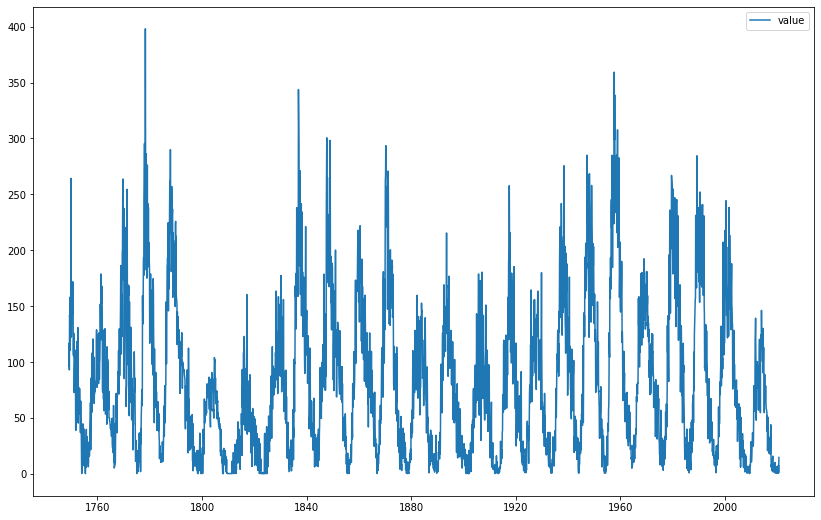

In [12]:
plt.figure(figsize=(14, 9))
plt.plot(df, label="value")
plt.legend()
plt.show()

In [13]:
values = df.values.flatten()

Усредняющий фильтр **smooth** с заданной шириной окна:

In [14]:
def smooth(a, windowWidth):
    out0 = np.convolve(a, np.ones(windowWidth, dtype=int), 'valid') / windowWidth    
    r = np.arange(1, windowWidth-1,2)
    start = np.cumsum(a[:(windowWidth-1)-1])[::2] / r
    stop = (np.cumsum(a[:-(windowWidth-1):-1])[::2] / r)[::-1]
    return np.concatenate((start, out0, stop)) / 300

Зададим ширину окна и сгладим данные:

In [15]:
widthWindow = 12
smoothValues = smooth(values, widthWindow)

Обновим данные в датафрейме на сглаженные и зададим начало в соответствии с вариантом.

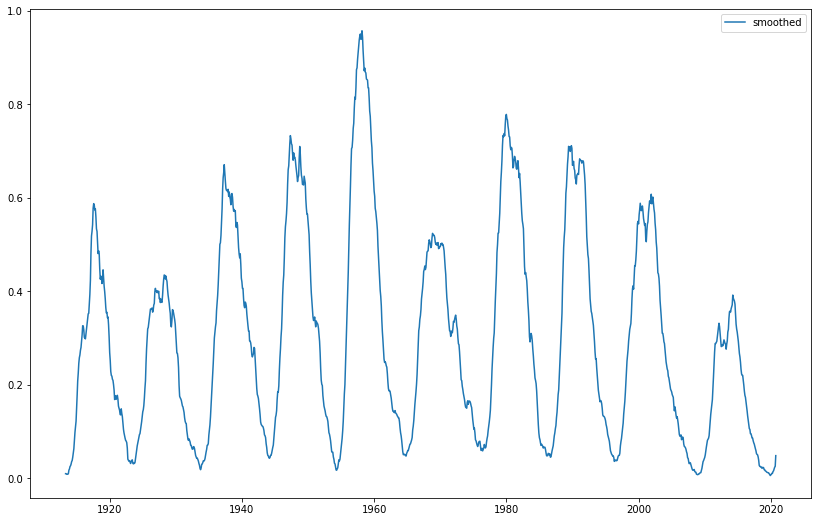

In [16]:
shift = df.values.size - smoothValues.size
df.iloc[shift:] = smoothValues[:, np.newaxis]

df = df[df.index >= pd.to_datetime(date)]

plt.figure(figsize=(14, 9))
plt.plot(df, label="smoothed")
plt.legend()
plt.show()

Сформируем обучающее множество (сразу с задержками) и тестовое множество для многошагового прогноза.

In [17]:
deep = 5

In [18]:
trainSize = int(len(df) * 0.7)
train = df[:trainSize]
test = df[trainSize:]

trainData = train.values.squeeze()
xTrain = np.array([trainData[i:i + deep] for i in range(len(trainData) - deep)])
yTrain = train.iloc[deep:].values

testData = test.values.squeeze()
xTest = np.array([testData[i:i + deep] for i in range(len(testData) - deep)])
yTest = test.iloc[deep:].values

Создадим и обучим нейронную сеть:

In [19]:
model = Sequential()
model.add(Dense(12, input_dim=deep, activation='tanh'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(xTrain, yTrain, epochs=60, batch_size=2, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


Выход сети:

In [20]:
predictTrain = model.predict(xTrain)

MSE = mean_squared_error(yTrain, predictTrain)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.00022043349361815633
RMSE = 0.01484700284967159


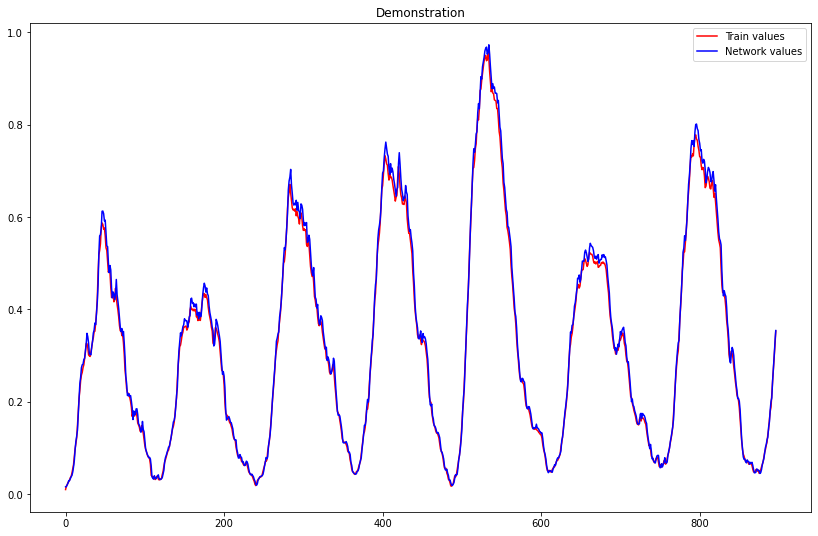

In [21]:
plt.figure(figsize=(14, 9))

plt.plot(yTrain, color='red')
plt.plot(predictTrain, color='blue')

plt.legend(['Train values', 'Network values'])
plt.title("Demonstration")
plt.show()

In [22]:
predictTest = model.predict(xTest)

MSE = mean_squared_error(yTest, predictTest)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.00017919801293520986
RMSE = 0.013386486205693033


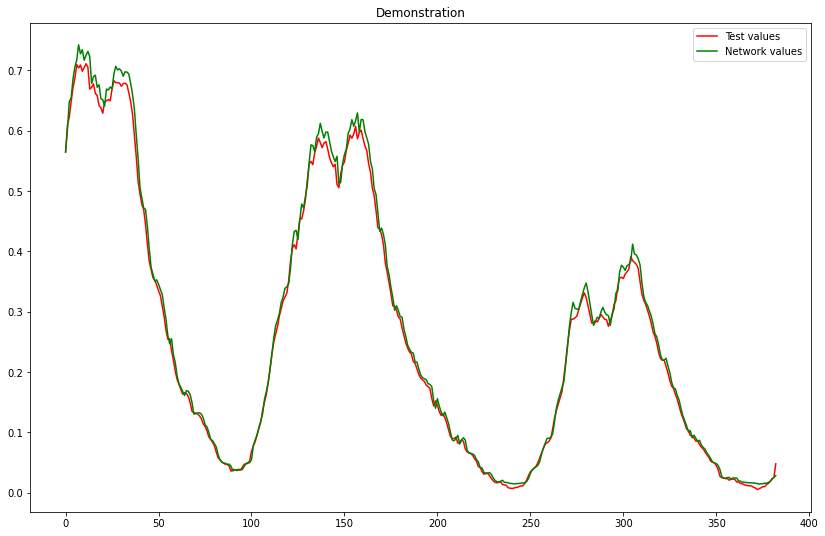

In [23]:
plt.figure(figsize=(14, 9))

plt.plot(yTest, color='red')
plt.plot(predictTest, color='green')

plt.legend(['Test values', 'Network values'])
plt.title("Demonstration")
plt.show()

### Задание №2

Построить и обучить *сеть прямого распространения с распределенным запаздыванием (Distributed Time-Delay Neural Network, TDNN)*, которая будет выполнять распознавание динамического образа.

Сгенерируем набор из  точек:

In [24]:
p1_k = np.linspace(0, 1, int(1 / 0.025), endpoint=True)

# main signal
p1 = np.sin(4 * np.pi * p1_k)

t1 = np.ones(len(p1_k)) * (-1)


p2_k = np.linspace(2.47, 4.26, int(1.79 / 0.025), endpoint=True)

# predict signal
p2 = np.cos(np.cos(p2_k) * p2_k * p2_k)

t2 = np.ones(len(p2_k))

# delay
R = np.array([7, 1, 3])

p2 = p2.reshape(1, p2.shape[0])
t2 = t2.reshape(1, t2.shape[0])

In [25]:
P = np.concatenate((numpy.matlib.repmat(p1, 1, R[0]), p2,
                    numpy.matlib.repmat(p1, 1, R[1]), p2,
                    numpy.matlib.repmat(p1, 1, R[2]), p2), axis=1).reshape(-1, 1)

T = np.concatenate((numpy.matlib.repmat(t1, 1, R[0]), t2,
                    numpy.matlib.repmat(t1, 1, R[1]), t2,
                    numpy.matlib.repmat(t1, 1, R[2]), t2), axis=1).reshape(-1, 1)

T = T.ravel() # makes 1-D array
P = P.ravel()

Создадим и обучим сеть с задержками, равными $5$:

In [26]:
nn = pyrenn.CreateNN([1, 8, 1], dIn=[5], dIntern=[5])

nn = pyrenn.train_LM(P, T, nn, E_stop=1e-5, k_max=200)

Maximum number of iterations reached


Выход сети:

In [27]:
output = pyrenn.NNOut(P, nn)

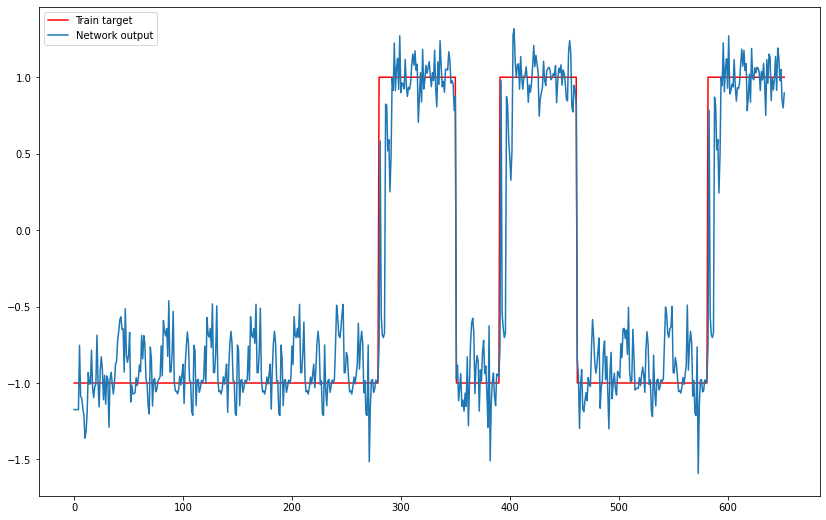

In [28]:
plt.figure(figsize=(14, 9))
plt.plot(T, color='red')
plt.plot(output)
plt.legend(['Train target', 'Network output'])
plt.show()

In [29]:
output[output >= 0] = 1.0
output[output < 0] = -1.0

MSE = mean_squared_error(T.reshape(T.shape[0]), output)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.09188361408882083
RMSE = 0.3031231005529285


Для проверки качества распознавания сформируем новое обучающее множество, изменив одно из значений $R$.

In [30]:
P2 = np.concatenate((numpy.matlib.repmat(p1, 1, R[0]), p2,
                    numpy.matlib.repmat(p1, 1, R[1]), p2,
                    numpy.matlib.repmat(p1, 1, 12), p2), axis=1).reshape(-1, 1)

T2 = np.concatenate((numpy.matlib.repmat(t1, 1, R[0]), t2,
                    numpy.matlib.repmat(t1, 1, R[1]), t2,
                    numpy.matlib.repmat(t1, 1, 12), t2), axis=1).reshape(-1, 1)

T2 = T2.ravel() # makes 1-D array
P2 = P2.ravel()

In [31]:
output2 = pyrenn.NNOut(P2, nn)

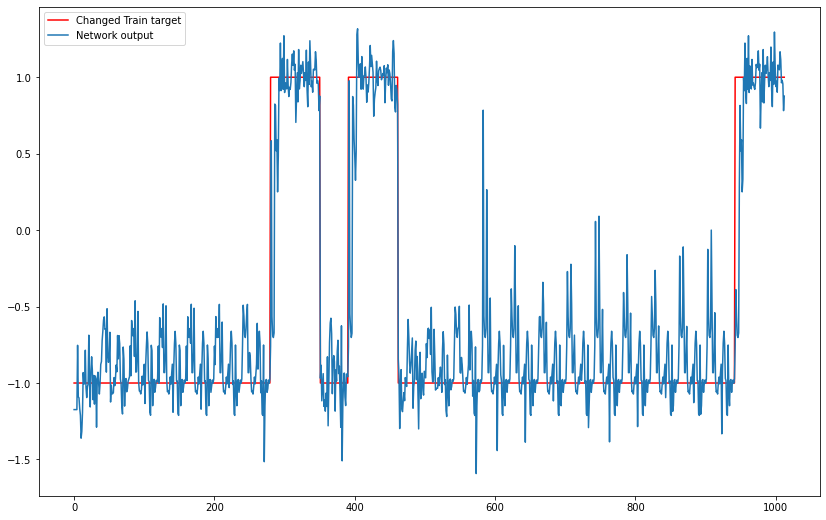

In [32]:
plt.figure(figsize=(14, 9))

plt.plot(T2, color='red')
plt.plot(output2)
plt.legend(['Changed Train target', 'Network output'])
plt.show()

In [33]:
output2[output2 >= 0] = 1.0
output2[output2 < 0] = -1.0

MSE = mean_squared_error(T2, output2)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.08292201382033564
RMSE = 0.28796182701937356


### Задание №3

Построить и обучить *нелинейную авторегрессионную сеть с внешними входами (Non-linearAutoRegressive network with eXogeneous inputs, NARX)*, которая будет выполнять аппроксимациютраектории динамической системы, также выполнить многошаговый прогноз значений системы.

Сформируем данные:

In [34]:
k = np.linspace(0, 10, (int)(10/0.01))

y = f(k)

In [35]:
inpt = u(k)[:, np.newaxis]
target = y

In [36]:
# data parameters:
delay = 3
trainSize = 700
testSize = 200
validSize = 97
shift=10

xTrain = k[:700]
xTest = k[700:900]
xValid = k[900:997]

yTrain = y[:700]
yTest = y[700:900]
yValid = y[900:997]

Создадим и обучим сеть:

In [37]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,
                         auto_order=2, exog_order=[2], exog_delay=[delay])

In [38]:
narx.fit(inpt, target)

Аппроксимируем систему:

In [39]:
output = narx.predict(inpt, target, step=1)

output[np.isnan(output)] = 0
MSE = mean_squared_error(target, output)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.25673744863823744
RMSE = 0.5066926569807751


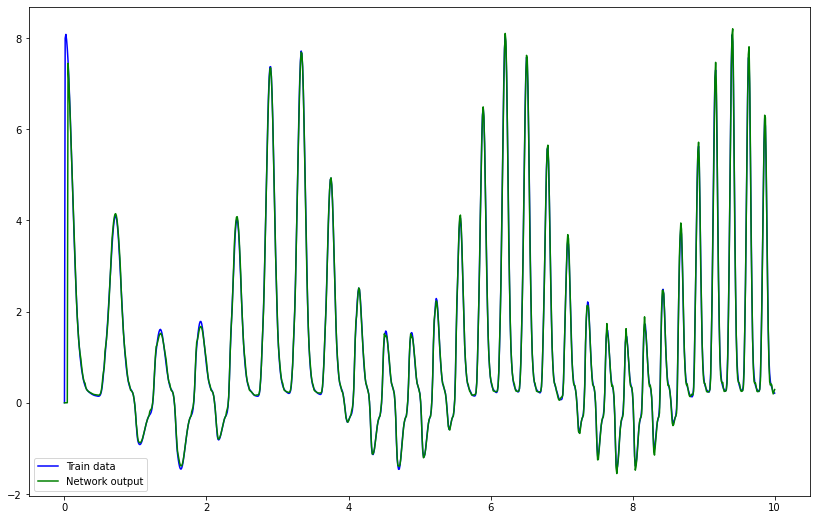

In [40]:
plt.figure(figsize=(14, 9))

plt.plot(k, y, color='blue')
plt.plot(k, output, color='green')
plt.legend(['Train data', 'Network output'])
plt.show()

Выполним многошаговый прогноз: обучим и рассчитаем выход сети для тестового подмножества. 

In [41]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,
                         auto_order=2, exog_order=[delay], exog_delay=[delay])
narx.fit(inpt, target)

In [42]:
inputTest = u(xTest)[:, np.newaxis]
targetTest = yTest
outputTest = narx.predict(inputTest, targetTest, step=3)

In [43]:
outputTest[np.isnan(outputTest)] = 0
MSE = mean_squared_error(targetTest, outputTest)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.25128735287680626
RMSE = 0.501285699852695


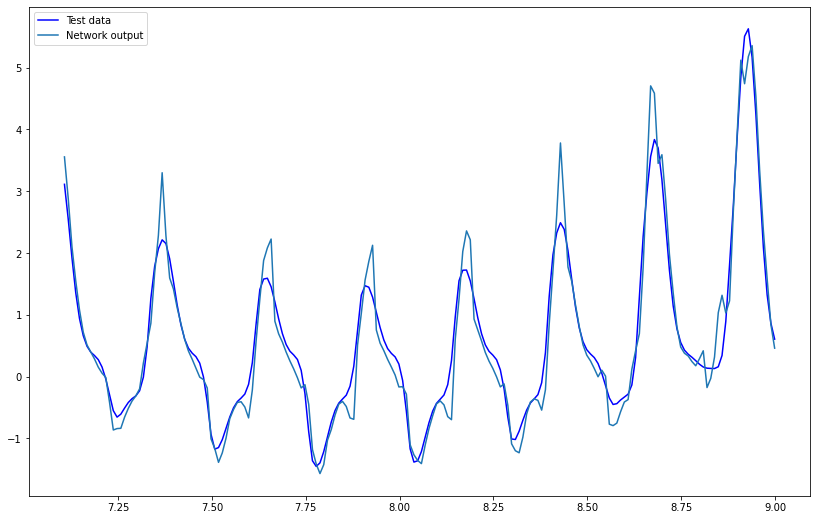

In [44]:
plt.figure(figsize=(14, 9))

plt.plot(xTest[shift:], yTest[shift:], color='blue')
plt.plot(xTest[shift:], outputTest[shift:])
plt.legend(['Test data', 'Network output'])
plt.show()

# Выводы:
Наиболее интересными из динамических сетей для меня кажутся рекурентные. С их помощью были созданы такие сети как GPT или BERT которые способны делать то, что ранее казалось способны сделать только люди. Если говорить о результатах заданий, то в первом мы снова видим "запоминание" промежутков, как в 4-й ЛР.